Functions
---------------

In [119]:
import os
import sys

WDIR = '/home/jdv/code/activmask/activmask'
sys.path.insert(0, os.path.dirname(WDIR))
os.chdir(WDIR)

from activmask.datasets.msdd import HeartMSDDataset, LiverMSDDataset, PancreasMSDDataset, ColonMSDDataset
from activmask.datasets.synth import SyntheticDataset
from activmask.datasets.xray import JointDataset, JointXRayRSNADataset
from activmask.models.loss import compare_activations, get_grad_saliency
from activmask.models.resnet import ResNetModel
from collections import OrderedDict
from copy import copy
from glob import glob
from skimage import io
from textwrap import wrap
import argparse
import datetime
import itertools
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pprint
import random
import seaborn as sns
import time
import torch
import torch.nn as nn
import yaml
from skimage.filters import gaussian


%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

# GLOBALS
SEEDS=[1111, 1234, 3232, 3221, 9856, 1290, 1987, 3200, 6400, 8888, 451] # 1111 replaces 3200
RESULTS_DIR = "/home/jdv/code/activmask/results"
LAST_MODEL_NAME = "last_model_1234.pth.tar"
BEST_MODEL_NAME = "best_model_1234.pth.tar"
ALPHA = 0.33
GRADMASK_THRESHOLD = 50
NSAMPLES = 50
CUDA = True
LO = np.nextafter(0, 1)
SIGMA = 1


def load_model(model_path):
    """ Loads a checkpointed model to the CPU. 
    Note: this is very sensitive to the path. Check the current directory
    is set correctly in the import statements if you get 'module not found'
    errors.
    """
    return torch.load(model_path, map_location='cuda' if CUDA else 'cpu')


def get_metrics(path, best=False, last=False):
    """
    Loads the outputs of training, if best, only 
    keeps best epoch for each dataframe.
    """

    def _convert_dtype(dictionary):
        """
        Converts all entries in all subdictionaries to be of datatype
        [int, float, str]. All non-matching entries are converted to str.
        """
        TYPES = [float, int, str, np.float32, np.float64, bool]
    
        for d in dictionary:
            if type(d) == dict:
                d = _convert_dtype(d)
            else:
                if type(dictionary[d]) not in TYPES:
                    dictionary[d] = str(dictionary[d])
    
    assert not all([best, last])
    
    all_df = []
    files = glob(os.path.join(path, "*/stats_*.pkl"))
    files.sort()
    
    for f in files:
        d = pickle.load(open(f,"rb"))
        _convert_dtype(d)
        d = pd.DataFrame.from_dict(d)
                
        if best:
            # Offset by 1 because of a bug in how "best" stats are stored.
            # Data at best_epoch are all actually the second-best epoch.
            best_epoch = d.iloc[-1]['best_epoch']
            d = d[d['this_epoch'] == best_epoch]
        elif last:
            last_epoch = d.iloc[-1]['this_epoch']
            d = d[d['this_epoch'] == last_epoch]

        d['source'] = f  # Keep track of the source file.
        all_df.append(d)

    return pd.concat(all_df)


def df_cleaner(df, keep=['auc', 'seed'], remove=[], verbose=False):
    """Selects the columns of the metrics dataframe to keep."""
    for col in df.columns:
        if not any([string in col for string in keep]):
            del df[col]
        elif any([string in col for string in remove]):
            del df[col]
            
    # Experiment name is determined by the configuration file used.
    experiments = df.experiment_name.unique()

    if verbose:
        print("resulting df \nshape={} tracking {} experiments, \nexperiments={}".format(
            df.shape, len(experiments), df.experiment_name.unique()))

    return(df)


def df_experiment_filter(df, name):
    """Keeps only experiments from df containing substring."""
    return df[df['experiment_name'].str.contains(name)]


def df_experiment_remover(df, name):
    """Removes all experiments from df containing substring."""
    return df[~df['experiment_name'].str.contains(name)]


def get_performance_metrics(path, best=False):
    KEEP = ["auc", "best", "seed", "epoch", "name", "source"]
    return df_cleaner(get_metrics(path, best=best), keep=KEEP)


def get_best_hyperparameters(path):
    KEEP = ['name', 'blur', 'actdiff', 'rrr', 'disc', 'gradmask', 'lr', 'type', 'acts']
    FILTER = ['loss']
    df =  df_cleaner(get_metrics(path, best=True), keep=KEEP, remove=FILTER)
    df =  df[df['experiment_name'].str.contains('search')]
    return df
    

def get_last_results_at_epoch(df, epoch, sig_digits=3):
    """Get the train/test/valid AUC at the final, not best, epoch."""
    #groups = ['experiment_name', 'actdiff_lambda', 'recon_lambda']
    fmt_str = "${0:." + str(sig_digits) + "f}\pm{1:." + str(sig_digits) + "f}$"
    
    groups = ['experiment_name']
    cols = ['train_auc', 'valid_auc', 'best_epoch']
    
    df = get_results_at_epoch(df, epoch, groups, cols)
    df = df.round(sig_digits)
    
    results = [] 
    for a, b in zip(df["train_auc"], df["train_auc_std"]):
        results.append(fmt_str.format(a, b))
    df['train_auc'] = results 
    df = df.drop(['train_auc_std'], axis=1)

    results = [] 
    for a, b in zip(df["valid_auc"], df["valid_auc_std"]):
        results.append(fmt_str.format(a, b))
    df['valid_auc'] = results 
    df = df.drop(['valid_auc_std'], axis=1)
    
    results = [] 
    for a, b in zip(df["best_epoch"], df["best_epoch_std"]):
        results.append(fmt_str.format(a, b))
    df['best_epoch'] = results 
    df = df.drop(['best_epoch_std'], axis=1)
    
    return df


def make_results_table(dfs, sig_digits=3, mode='score', count=False):
    """
    Merge the best test results for all dataframes submitted. 
    Used to make a results table across datasets.
    """  
    fmt_str = "${0:." + str(sig_digits) + "f}\pm{1:." + str(sig_digits) + "f}$"

    assert mode in ['score', 'loc']
    y
    for i, df in enumerate(dfs):
        _df = copy(df)
        
        # Strip the dataset name out of the experiment name.        
        name = _df['experiment_name'].iloc[0].split('_')[0]
        _df['experiment_name'] = _df['experiment_name'].str.replace('{}_'.format(name), '')
        
        # Reformat the table.
        _df = get_test_results(_df, count=count)
        _df = _df.round(sig_digits)

        # Merge mean+/-std into a single column with the experiment name.
        auc, iou = [], [] 
        for a, b, c, d in zip(_df["best_test_score"], _df["best_test_score_std"], _df["iou"], _df["iou_std"]):
            auc.append(fmt_str.format(a, b))
            iou.append(fmt_str.format(c, d))
            
        #if mode == 'score':
        _df['test_auc_{}'.format(name)] = auc
        #elif mode == 'loc':
        _df['test_iou_{}'.format(name)] = iou
        
        _df = _df.drop(['best_test_score', 'best_test_score_std', 'iou', 'iou_std'], axis=1)
        
        # Merge the experiments.
        if i == 0:
            final_df = copy(_df)
        else:
            final_df = pd.merge(final_df, _df, on='experiment_name')
    
    return final_df


def df_deduplicate(df):
    return df.loc[:,~df.columns.duplicated()]


def loc_melt(df):
    return pd.melt(df.reset_index(), 
                   id_vars=['experiment_name', 'test_auc'], 
                   value_vars=['iop', 'iou', 'iot'], 
                   var_name='Loc', 
                   value_name='Score')


def get_results(df, groups, cols, count=False, mode='mean'):
    """
    Shows a reduced form of the table with mean and std values 
    over experiments.
    """
    df_tmp = df.groupby(groups)[cols]
    if mode == 'mean':
        df = df_tmp.mean().join(df_tmp.std(),rsuffix='_std')
    elif mode == 'max':
        df = df_tmp.max().join(df_tmp.std(),rsuffix='_std')
    if count:
        df = df.join(df_tmp.count(), rsuffix='_count')
                                                                        
    return df


def get_test_results(df, cols=['best_test_score', 'iou'], count=False):
    """Get the test results at the best epoch."""
    df = df_deduplicate(df)
    groups = ['experiment_name']
    return get_results(df, groups, cols, count=count, mode='mean')


#def seed_finder(df, experiment_name):
#    test = df[df.epoch == EPOCH]
#    test = test[test['experiment_name'] == experiment_name]
#
#    for seed in SEEDS:
#        if seed not in np.array(test['seed']):
#            print("{} missing {}".format(experiment_name, seed))


def threshold(x, percentile):
    return x * (x > np.percentile(x, percentile))    


def get_saliency(x, y_pred, percentile, absoloute=True, blur=True):
    """
    Saliency wrapper: returns the saliency map in numpy format. 
    Optionally takes the absoloute value, blurs the output and 
    thresholds the mask.
    """
    # Removes channel dimension, batch dimension.
    if len(y_pred.shape) == 1:
        y_pred = y_pred.unsqueeze(0)  # Add batch dimension back.
    
    saliency = get_grad_saliency(x, y_pred).detach().cpu().numpy()[0][0]
        
    if absoloute:
        saliency = np.abs(saliency)

    if blur:
        saliency = gaussian(saliency, 
                            mode='constant', 
                            sigma=(SIGMA, SIGMA), 
                            truncate=3.5,
                            preserve_range=True)
    
    if percentile > 0:
        saliency = threshold(saliency, percentile)

    return saliency


def load_dataset(name, seed, nsamples=None):
    assert name in ['synth', 
                    'msd_cardiac', 
                    'msd_liver', 
                    'msd_colon', 
                    'msd_pancreas', 
                    'xray', 
                    'xray_bal',
                    'rsna',
                    'rsna_bal']
    if name == 'synth':
        return SyntheticDataset(
            dataroot="/home/jdv/code/activmask/data/synth_hard",
            mode='distractor3',
            distract_noise=1, 
            nsamples=128 if not nsamples else nsamples,
            seed=seed)
    elif name == 'msd_cardiac':
        return HeartMSDDataset(
            base_path='/srv/data/msd', 
            mode='test', 
            nsamples=128 if not nsamples else nsamples, 
            blur=0,
            seed=seed)
    elif name == 'msd_liver':
        return LiverMSDDataset(
            base_path='/srv/data/msd', 
            mode='test', 
            blur=0, 
            nsamples=128 if not nsamples else nsamples,
            seed=seed)
    elif name == 'msd_colon':
        return ColonMSDDataset(
            base_path='/srv/data/msd', 
            mode='test', 
            nsamples=128 if not nsamples else nsamples,
            seed=seed)
    elif name == 'msd_pancreas':
        return PancreasMSDDataset(
            base_path='/srv/data/msd', 
            mode='test', 
            nsamples=128 if not nsamples else nsamples,
            seed=seed)
    elif name == 'xray':
        return JointDataset(
            "/srv/data/xray/NIH/images-224",
            "/srv/data/xray/NIH/Data_Entry_2017.csv",
            "/srv/data/xray/PC/images-224",
            "/srv/data/xray/PC/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv",
            mode='test', 
            seed=seed, 
            ratio=0.9,
            nsamples=nsamples,
            new_size=224)
    elif name == 'xray_bal':
        return JointDataset(
            "/srv/data/xray/NIH/images-224",
            "/srv/data/xray/NIH/Data_Entry_2017.csv",
            "/srv/data/xray/PC/images-224",
            "/srv/data/xray/PC/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv",
            mode='test', 
            seed=seed, 
            ratio=0.5,
            nsamples=nsamples,
            new_size=224)
    elif name == 'rsna':
        return JointXRayRSNADataset(
            imgpath="/srv/data/xray/RSNA/stage_2_train_images_jpg",
            ratio=0.9,
            mode="test",
            seed=seed,
            nsamples=nsamples,
            new_size=224)
    elif name == 'rsna_bal':
        return JointXRayRSNADataset(
            imgpath="/srv/data/xray/RSNA/stage_2_train_images_jpg",
            ratio=0.5,
            mode="test",
            seed=seed,
            nsamples=nsamples,
            new_size=224)

    
def add_loc_scores(df, dataset_name, img_size, model_type='resnet', nsamples=None):
    
    iops, ious, iots = [], [], []
    #for e in ["{}_{}", "{}_{}_actdiff", "{}_{}_clfmasked", "{}_{}_discriminator", 
    #          "{}_{}_gradmask"]:
    #    experiment_names.append(e.format(exp_name, model_type))
    #
    #results = {'experiment_name': [], 'iop': [], 'iou': [], 'iot': []}

    
    for index, row in df.iterrows():
        source_file = row['source']
        seed = int(os.path.basename(source_file).split('_')[-1].split('.')[0])
        model_name = os.path.join(
            os.path.dirname(source_file), 'best_model_{}.pth.tar'.format(seed))
        dataset = load_dataset(dataset_name, seed, nsamples=nsamples)
        model = load_model(model_name)
        iop, iou, iot = calc_loc_scores(dataset, model, img_size)
        iops.append(iop)
        ious.append(iou)
        iots.append(iot)
    
    df['iop'] = iops
    df['iou'] = ious
    df['iot'] = iots
    return df    

    
def calc_loc_scores(dataset, model, img_size, absoloute=True):
            
    def _get_bin_loc_scores(locs, segs):
        EPS = 10e-16
        iou = (segs & locs).sum() / ((segs | locs).sum() + EPS)                             
        iop = (segs & locs).sum() / (locs.sum() + EPS)                               
        iot = (segs & locs).sum() / (segs.sum() + EPS)                       
                                                                                
        return (iou, iop, iot)
    
    ious, iops, iots = [], [], []
    
    for sample in dataset:
        
        x, seg, y = sample
        x = torch.tensor(x).to('cuda' if CUDA else 'cpu')
        y = torch.tensor(y).to('cuda' if CUDA else 'cpu')

        # Only calculate for the positive class.
        if y == 0:
            continue
        
        seg = seg[0, ...]
        
        if seg.sum() == 0:
            continue
        
        # Saliency map for each image.
        percentile = 100 - ((torch.sum(seg) / img_size**2) * 100)
                
        x_var = torch.autograd.Variable(torch.clone(x).unsqueeze(0), requires_grad=True)
        outputs = model(x_var, seg)
        salience_map = get_saliency(
            x_var, outputs['y_pred'], percentile, absoloute=absoloute, blur=True)
        locs_bin = np.zeros((img_size, img_size)).astype(np.bool)
        idx = salience_map > 0
        locs_bin[idx] = 1
        seg = seg.detach().numpy().astype(np.bool)
        
        iou, iop, iot = _get_bin_loc_scores(locs_bin, seg)
        ious.append(iou)
        iops.append(iop)
        iots.append(iot)
        
    return (np.mean(ious), np.mean(iops), np.mean(iots))


def plot_search_space(pattern, title, seed, bal=False):
    """
    Generates skopt search results for a visualization of the 
    difficulty of tuning different models.
    """
    
    def get_opt(state):
        """Loads a checkpoint, extracting the skopt state."""
        with open(state, 'rb') as f:
            d = torch.load(f)
        return d['hp_opt']


    def get_search_results(searches, seed, model='resnet'):
        """
        Given a list of folders, retrieve the skopt 
        checkpoint and load search results.
        """
        search_results = OrderedDict()
        NAME_MAP = {'{}'.format(model): 'Baseline',
                   '{}_actdiff'.format(model): 'Actdiff',
                   '{}_clfmasked'.format(model): 'Masked',
                   '{}_discriminator'.format(model): 'Discriminator',
                   '{}_gradmask'.format(model): 'Gradmask',
                   '{}_rrr'.format(model): 'RRR'}
    
        searches.sort()
        for search in searches:
            state_file = os.path.join(search, 'skopt_checkpoint_{}.pth.tar'.format(seed))
            hp_opt = get_opt(state_file)
        
            name = '_'.join(os.path.basename(os.path.dirname(state_file)).split('_')[1:])
            if name in NAME_MAP:
                search_results[NAME_MAP[name]] = {
                    'x': hp_opt.Xi, 'y': np.abs(hp_opt.yi)}
    
        return search_results


    def label(x, color, label):
        """Labels an axes"""
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
 
    def fix_scores(scores):
        """
        Adds a small amount of non-negative noise to all scores so that 
        constant results (like all-0) are rendered.
        """
        EPS = 0.0000001
        add_noise = lambda x: x + (np.random.random(1) * EPS)
        idx = np.where(scores <= 0.99)[0]
        for i in idx:
            scores[i] = add_noise(scores[i])

        assert np.max(scores) <= 1
        assert np.min(scores) >= 0
            
        return scores

    SCORE_NAME = "AUC"

    # Ugly logic to handle the naming of the xray balanced task.
    searches = glob('{}_{}*'.format(pattern, 'resnet-bal' if bal else 'resnet'))
    searches.sort()
    
    if not bal:
        searches = list(filter(lambda x: 'bal' not in x, searches))
    
    search_results = get_search_results(searches, seed, model='resnet-bal' if bal else 'resnet')
    
    # Make a long-form dataframe.
    scores, experiment_names = [], []
    
    for experiment, result in search_results.items():
        aucs = np.array(result['y'])
        names = np.array([experiment] * len(aucs))

        scores.append(aucs)
        experiment_names.append(names)
    
    scores = fix_scores(np.concatenate(scores))
    experiment_names = np.concatenate(experiment_names)
    df = pd.DataFrame({SCORE_NAME: scores, 'name': experiment_names})

    # Plotting
    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    pal = sns.cubehelix_palette(len(np.unique(experiment_names)), rot=-.25, light=.5)
    g = sns.FacetGrid(df, row="name", hue='name', aspect=10, height=0.75, palette=pal)
    
    g.map(sns.kdeplot, SCORE_NAME, clip_on=False, shade=True, alpha=1, lw=1.5, bw=.002)
    #g.map(sns.kdeplot, "auc", clip_on=False, color="w", lw=2, bw=.002)
    g.map(plt.axhline, y=0, lw=0.1, clip_on=False)
    g.map(label, SCORE_NAME)

    g.fig.subplots_adjust(hspace=-.25)
    g.set_titles("")
    g.fig.suptitle(title)
    g.set(yticks=[])
    g.despine(bottom=True, left=True)

    plt.show()


def ax_lineplot(ax, df_filter, y_min, title, legend=False, remove=''):
    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'legend.frameon':True})
    
    palette = {
        '{}'.format(df_filter): "black",
        '{}_actdiff'.format(df_filter): "red",
        '{}_clfshuffle'.format(df_filter): "blue",
        '{}_discriminator'.format(df_filter): "orange",
        '{}_gradmask'.format(df_filter): "darkviolet",
        '{}_rrr'.format(df_filter): "green"
    }
    
    names = ["Experiment", "Baseline", "ActDiff", 
             "Masked", "Adversarial", "GradMask", "RRR"]
    
    _df = df_experiment_filter(get_performance_metrics(RESULTS_DIR), df_filter)
    if len(remove) > 0:
        _df = df_experiment_remover(_df, remove)

    g = sns.lineplot(
        x="this_epoch", y='valid_auc', hue='experiment_name', 
        ax=ax, data=_df, palette=palette, hue_order=sorted(list(palette.keys())))
    g.set_title(title)
    
    if legend:
        legend = g.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
        for t, l in zip(legend.texts, names):
            t.set_text(l)
    else:
        g.get_legend().remove()

    g.set_ylim(y_min, 1.05) 
    g.set_xlabel('Epoch')
    g.set_ylabel('Valid AUC')

    
def render_mean_grad_wrapper(dataset_name, n_samples, exp_name, title, size, model_name,
                             model_type='resnet', absoloute=True, crop_mask=0):
    base_mdls = glob(os.path.join(RESULTS_DIR, "{}_{}/best_model_*".format(exp_name, model_type)))
    mask_mdls = glob(os.path.join(RESULTS_DIR, "{}_{}_clfshuffle/best_model_*".format(exp_name, model_type)))
    disc_mdls = glob(os.path.join(RESULTS_DIR, "{}_{}_discriminator/best_model_*".format(exp_name, model_type)))
    actd_mdls = glob(os.path.join(RESULTS_DIR, "{}_{}_actdiff/best_model_*".format(exp_name, model_type)))
    grad_mdls = glob(os.path.join(RESULTS_DIR, "{}_{}_gradmask/best_model_*".format(exp_name, model_type)))
    rrr_mdls = glob(os.path.join(RESULTS_DIR, "{}_{}_rrr/best_model_*".format(exp_name, model_type)))
    
    render_mean_grad(dataset_name, n_samples, 
                     base_mdls, mask_mdls, disc_mdls, actd_mdls, grad_mdls, rrr_mdls,
                     title, img_size=size, absoloute=absoloute, crop_mask=crop_mask)
        

def render_mean_grad(dataset_name, nsamples, 
                     base_mdls, mask_mdls, disc_mdls, actd_mdls, grad_mdls, rrr_mdls,
                     exp_name, img_size=100, absoloute=True, crop_mask=0):
    """
    Renders the mean saliency map across all inputs in the dataset, from the
    input models for visual comparison.
    """
    fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(24, 6), dpi=150)
    axs = axs.ravel()
    datasets = {}  # Dict to cache our datasets per seed.
    #n = len(dataset)
    
    images, models = OrderedDict(), OrderedDict()
    names = ["Image", "A: Baseline", "B: Masked", 
             "C: Adversarial", "D: ActDiff", "E: GradMask", "F: RRR"]
    for name in names:
        images[name] = np.zeros((img_size, img_size))
        
    _mask = np.zeros((img_size, img_size))
    
    models['A: Baseline'] = base_mdls
    models['B: Masked'] = mask_mdls
    models['C: Adversarial'] = disc_mdls
    models['D: ActDiff'] = actd_mdls 
    models['E: GradMask'] = grad_mdls
    models['F: RRR'] = rrr_mdls
     
    def _get_seed(filename):
        return int(os.path.splitext(
            os.path.splitext(
                os.path.basename(filename))[0])[0].split('_')[-1])

    
    for model_name, models in models.items():
        
        for model in models:
            
            seed = _get_seed(model)
            model = load_model(model)
        
            # Fetches the dataset, either from disk or cache.
            dataset_key = "{}+{}".format(dataset_name, seed)
            if dataset_key not in datasets:
                datasets[dataset_key] = load_dataset(
                    dataset_name, seed, nsamples=nsamples)
    
            dataset = datasets[dataset_key]
    
            for sample in dataset:
          
                x, seg, y = sample
                x = torch.tensor(x).to('cuda' if CUDA else 'cpu')
                y = torch.tensor(y).to('cuda' if CUDA else 'cpu')

                # Only plot the positive cases.
                if y == 0:
                    continue
        
                _mask += seg.detach().cpu().numpy()[0]
                images["Image"] += torch.clone(x).detach().cpu().numpy()[0]
        
                # Add the gradients for each sample.
                x_var = torch.autograd.Variable(
                    torch.clone(x).unsqueeze(0), requires_grad=True)
                outputs = model(x_var, seg)
                images[model_name] += get_saliency(
                    x_var, outputs['y_pred'], 0, absoloute=absoloute, blur=True)
    
    mask_cmap = plt.cm.Reds
    mask_cmap.set_under('k', alpha=0)
    gradient_cmap = plt.cm.jet
    gradient_cmap.set_under('k', alpha=0)
    
    n = len(dataset)
    _mask /= n  # Normalize by dataset size.
    
    if crop_mask:
        _mask *= (_mask > np.percentile(_mask, crop_mask))

    for i, (name, image) in enumerate(images.items()):
        image /= n  # Normalize by dataset size.
        axs[i].set_title(name, size=24)
        axs[i].imshow(images["Image"], interpolation='none', cmap='Greys_r')
        
        # Plots the image with a transparent overlay of the mask.
        if name  == 'Image':
            axs[i].imshow(_mask, interpolation='none', cmap=mask_cmap, 
                          clim=[LO, _mask.max()], alpha=ALPHA)
            axs[i].set_ylabel(exp_name, size=24)
        # Plot gradients with image as background.
        else:
            axs[i].imshow(
                threshold(image, GRADMASK_THRESHOLD), interpolation='none', 
                cmap=gradient_cmap, clim=[LO, image.max()], alpha=ALPHA)

        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_ticks([])  # So label remains.
        #axs[i].axis('off')

    #plt.suptitle()
    plt.tight_layout()
    plt.show()


def plot_curves(names):
    
    x_size = 12 if len(names) > 1 else 5.5
    y_size = 3*(len(names)//2) if len(names) > 1 else 2.5
    n_rows = len(names) // 2 if len(names) > 1 else 1
    n_cols = 2 if len(names) > 1 else 1
    legend = 1 if len(names) > 1 else 0
        
    fig, axs = plt.subplots(
        figsize=(x_size, y_size), 
        nrows=n_rows, 
        ncols=n_cols,
        sharex=True, 
        sharey=False)
    
    # Handles length 1 lists of names.
    if not isinstance(axs, type(np.array)):
        axs = np.array(axs)

    for i, ax in enumerate(axs.ravel()):
        if len(names)-1 >= i:
            # Legend only for the first plot.
            (df_filter, title, y_min, remove) = names[i]
            ax_lineplot(ax, df_filter, y_min, title, 
                        legend=i == legend, remove=remove)
        else:
            ax.set_axis_off()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Collect Data from Disk

In [76]:
df_hparams = get_best_hyperparameters(RESULTS_DIR)
df_performance = get_performance_metrics(RESULTS_DIR, best=True)
df_synth_last = df_experiment_filter(get_performance_metrics(RESULTS_DIR, best=False), 'synth-search_')

In [42]:
df_experiment_filter(df_hparams, 'bal_actdiff')

,optimizer_Adam_lr,model_ResNetModel_actdiff_lamb,model_ResNetModel_gradmask_lamb,model_ResNetModel_disc_lamb,experiment_name,model_ResNetModel_save_acts,model_ResNetModel_disc_iter,model_ResNetModel_disc_lr,model_ResNetModel_rrr_lamb,dataset_train_SyntheticDataset_blur,model_ResNetModel_resnet_type
19,0.000010,3.875686,0.0,0.0,rsna-search_resnet-bal_actdiff,[5],NaN,NaN,NaN,NaN,NaN
20,0.008917,0.577742,0.0,0.0,xray-search_resnet-bal_actdiff,[5],NaN,NaN,NaN,NaN,18


In [5]:
# Synthetic Data Experiments
df_synth = df_experiment_filter(df_performance, 'synth-seeds')
df_synth['Dataset'] = "Synth"
df_synth = add_loc_scores(df_synth, 'synth', img_size=28)

In [77]:
# Collects the saliency map scores for all experime
df_xray = df_experiment_remover(df_experiment_filter(df_performance, 'xray-seeds_resnet'), 'resnet-bal')
df_xray['Dataset'] = "XRay SPC"
df_xray = add_loc_scores(df_xray, 'xray', img_size=224)

In [78]:
df_xray_bal = df_experiment_filter(df_performance, 'xray-seeds_resnet-bal')
df_xray_bal['Dataset'] = "XRay No SPC"
df_xray_bal = add_loc_scores(df_xray_bal, 'xray_bal', img_size=224)

In [10]:
# RSNA Experiments
df_rsna = df_experiment_remover(df_experiment_filter(df_performance, 'rsna-seeds_resnet'), 'resnet-bal')
df_rsna['Dataset'] = "RSNA VPC"
df_rsna = add_loc_scores(df_rsna, 'rsna', img_size=224)

In [17]:
df_rsna_bal = df_experiment_filter(df_performance, 'rsna-seeds_resnet-bal')
df_rsna_bal['Dataset'] = "RSNA No VPC"
df_rsna_bal = add_loc_scores(df_rsna_bal, 'rsna_bal', img_size=224)

# Hyperparameter Search Results

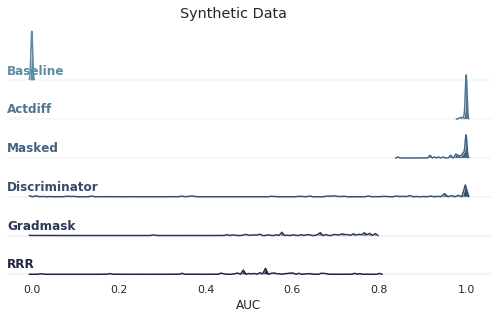

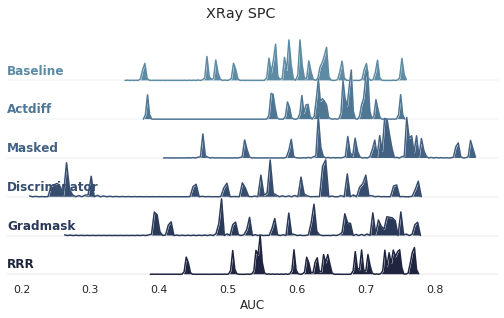

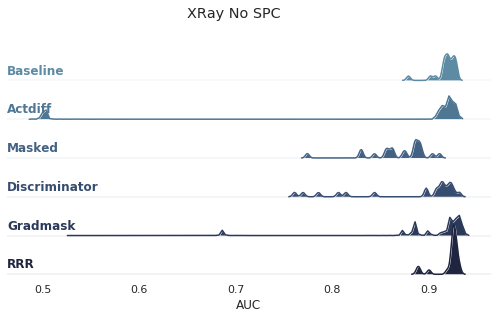

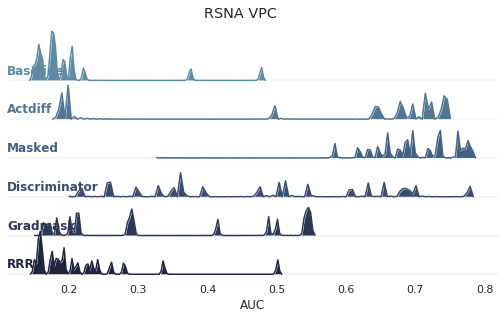

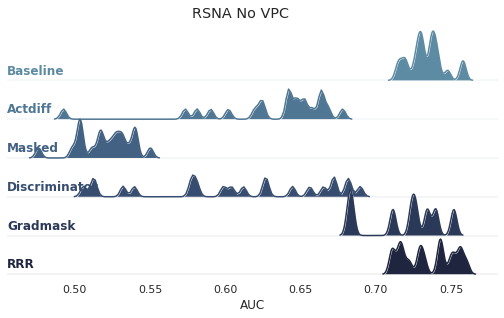

In [79]:
plot_search_space(os.path.join(RESULTS_DIR, 'synth-search'), "Synthetic Data", 1234);
plot_search_space(os.path.join(RESULTS_DIR, 'xray-search'), "XRay SPC", 1234, bal=False);
plot_search_space(os.path.join(RESULTS_DIR, 'xray-search'), "XRay No SPC", 1234, bal=True);
plot_search_space(os.path.join(RESULTS_DIR, 'rsna-search'), "RSNA VPC", 1234, bal=False);
plot_search_space(os.path.join(RESULTS_DIR, 'rsna-search'), "RSNA No VPC", 1234, bal=True);

# Plot Test Results on Seeds

In [80]:
get_test_results(df_synth, count=False)

,best_test_score,iou,best_test_score_std,iou_std
experiment_name,,,,
synth-seeds_resnet,0.000000,0.112466,0.000000,0.119957
synth-seeds_resnet_actdiff,0.999822,0.559637,0.000311,0.036099
synth-seeds_resnet_clfmasked,0.992876,0.687052,0.019693,0.038185
synth-seeds_resnet_clfshuffle,0.999976,0.649933,0.000077,0.042860
synth-seeds_resnet_discriminator,0.915550,0.675503,0.118076,0.038689
synth-seeds_resnet_gradmask,0.761663,0.612914,0.042242,0.031691
synth-seeds_resnet_rrr,0.493079,0.129761,0.083295,0.088378


In [81]:
get_test_results(pd.concat([df_deduplicate(df_xray), df_deduplicate(df_xray_bal)]), count=False)

,best_test_score,iou,best_test_score_std,iou_std
experiment_name,,,,
xray-seeds_resnet,0.696755,0.594006,0.046195,0.026335
xray-seeds_resnet-bal,0.927656,0.663515,0.007294,0.026026
xray-seeds_resnet-bal_actdiff,0.799113,0.582110,0.174794,0.213535
xray-seeds_resnet-bal_clfmasked,0.895010,0.602637,0.016289,0.018576
xray-seeds_resnet-bal_clfshuffle,0.897805,0.630086,0.013968,0.024081
xray-seeds_resnet-bal_discriminator,0.922908,0.632163,0.005670,0.025015
xray-seeds_resnet-bal_gradmask,0.936143,0.713356,0.004871,0.019028
xray-seeds_resnet-bal_maskall,0.909681,0.655469,0.007157,0.027020
xray-seeds_resnet-bal_rrr,0.927895,0.640145,0.005188,0.017592


In [82]:
get_test_results(pd.concat([df_deduplicate(df_rsna), df_deduplicate(df_rsna_bal)]), count=False)

,best_test_score,iou,best_test_score_std,iou_std
experiment_name,,,,
rsna-seeds_resnet,0.202878,0.128242,0.032985,0.005807
rsna-seeds_resnet-bal,0.760975,0.255994,0.016115,0.026315
rsna-seeds_resnet-bal_actdiff,0.596243,0.193853,0.024524,0.014614
rsna-seeds_resnet-bal_clfmasked,0.510720,0.098972,0.009920,0.052660
rsna-seeds_resnet-bal_clfshuffle,0.498589,0.093556,0.023858,0.039185
rsna-seeds_resnet-bal_discriminator,0.648580,0.144172,0.020082,0.030238
rsna-seeds_resnet-bal_gradmask,0.748037,0.254898,0.007662,0.043061
rsna-seeds_resnet-bal_maskall,0.373294,0.276322,0.281912,0.021866
rsna-seeds_resnet-bal_rrr,0.747778,0.237716,0.013262,0.054591


In [ ]:
# Synthetic Last Epoch Results.
#with open('tables/synth_last_results.tex','w') as tf:
#    tf.write(get_last_results_at_epoch(df_synth, EPOCH, sig_digits=2).to_latex())
#
#get_last_results_at_epoch(df_synth, EPOCH, sig_digits=2)


In [47]:
with open('notebooks/tables/all_synth_scores.tex', 'w') as tf:
    tf.write(make_results_table([df_synth], sig_digits=2, mode='score').to_latex(escape=False))

with open('notebooks/tables/all_rsna_vpc_scores.tex', 'w') as tf:
    tf.write(make_results_table([df_rsna], sig_digits=2, mode='score').to_latex(escape=False))
with open('notebooks/tables/all_rsna_novpc_scores.tex', 'w') as tf:
    tf.write(make_results_table([df_rsna_bal], sig_digits=2, mode='score').to_latex(escape=False))

with open('notebooks/tables/all_xray_spc_scores.tex', 'w') as tf:
    tf.write(make_results_table([df_xray], sig_digits=2, mode='score').to_latex(escape=False))
with open('notebooks/tables/all_xray_nospc_scores.tex', 'w') as tf:
    tf.write(make_results_table([df_xray_bal], sig_digits=2, mode='score').to_latex(escape=False))

# Training Curves

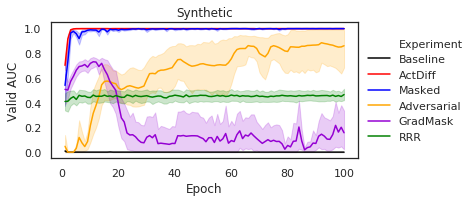

In [91]:
names = [('synth-seeds_resnet', 'Synthetic', -0.05, '')]
plot_curves(names)

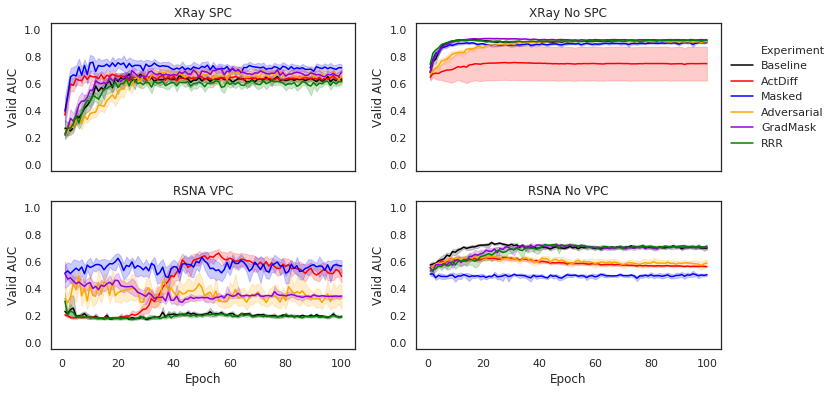

In [90]:
names = [
    ('xray-seeds_resnet', 'XRay SPC', -0.05, 'bal'),
    ('xray-seeds_resnet-bal', 'XRay No SPC', -0.05, ''),
    ('rsna-seeds_resnet', 'RSNA VPC', -0.05, 'bal'),
    ('rsna-seeds_resnet-bal', 'RSNA No VPC', -0.05, '')
    ]
plot_curves(names)

# Datasets

In [ ]:
def view_dataset_wrapper(blur=0, nsamples=10):
    dataset = HeartMSDDataset(
        base_path='/srv/data/msd', mode='test', nsamples=nsamples, blur=blur)
    view_dataset(dataset)

def view_dataset(dataset):
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18, 18), dpi=72)
    ALPHA = 0.50
    mask_cmap = plt.cm.Reds
    mask_cmap.set_under('k', alpha=0)

    for ax, sample in zip(axs.ravel(), dataset):
        
        x, seg, y = sample

        image = torch.clone(x).detach().cpu().numpy()[0]
        mask = seg.detach().cpu().numpy()[0]
        
        ax.imshow(image, interpolation='none', cmap='Greys_r')
        if y == 1:
            ax.imshow(mask, interpolation='none', cmap=mask_cmap, clim=[0.000001, mask.max()], alpha=ALPHA)
        ax.set_title('label={}'.format(y))

view_dataset_wrapper(blur=2, nsamples=10)

# Mean Saliency Maps / Dataset-Level Stats

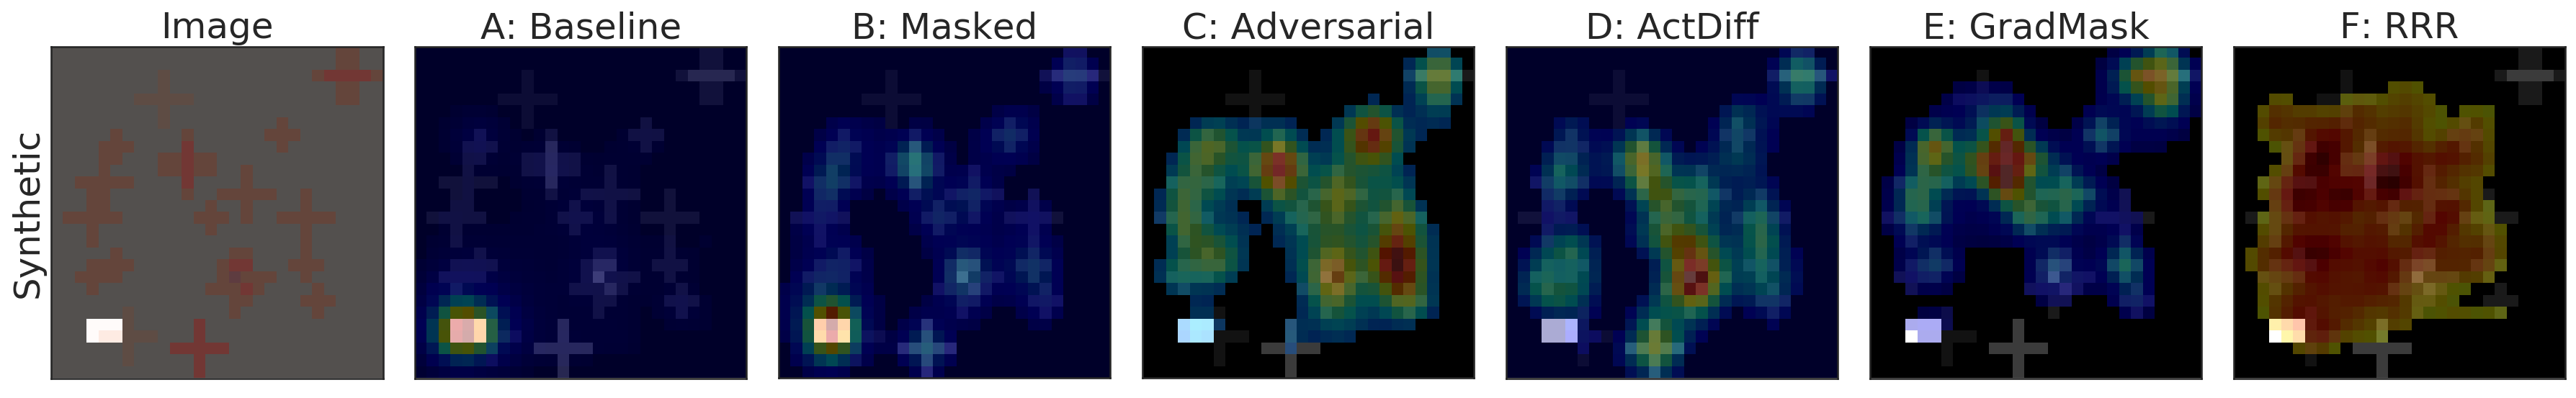

In [148]:
#dataset_name, n_samples, exp_name, title, size, model_name,
render_mean_grad_wrapper(
    'synth', 2, 'synth-seeds', 'Synthetic', size=28, model_name=BEST_MODEL_NAME)

/home/jdv/code/activmask/results/xray-seeds_resnet_clfshuffle/best_model_*


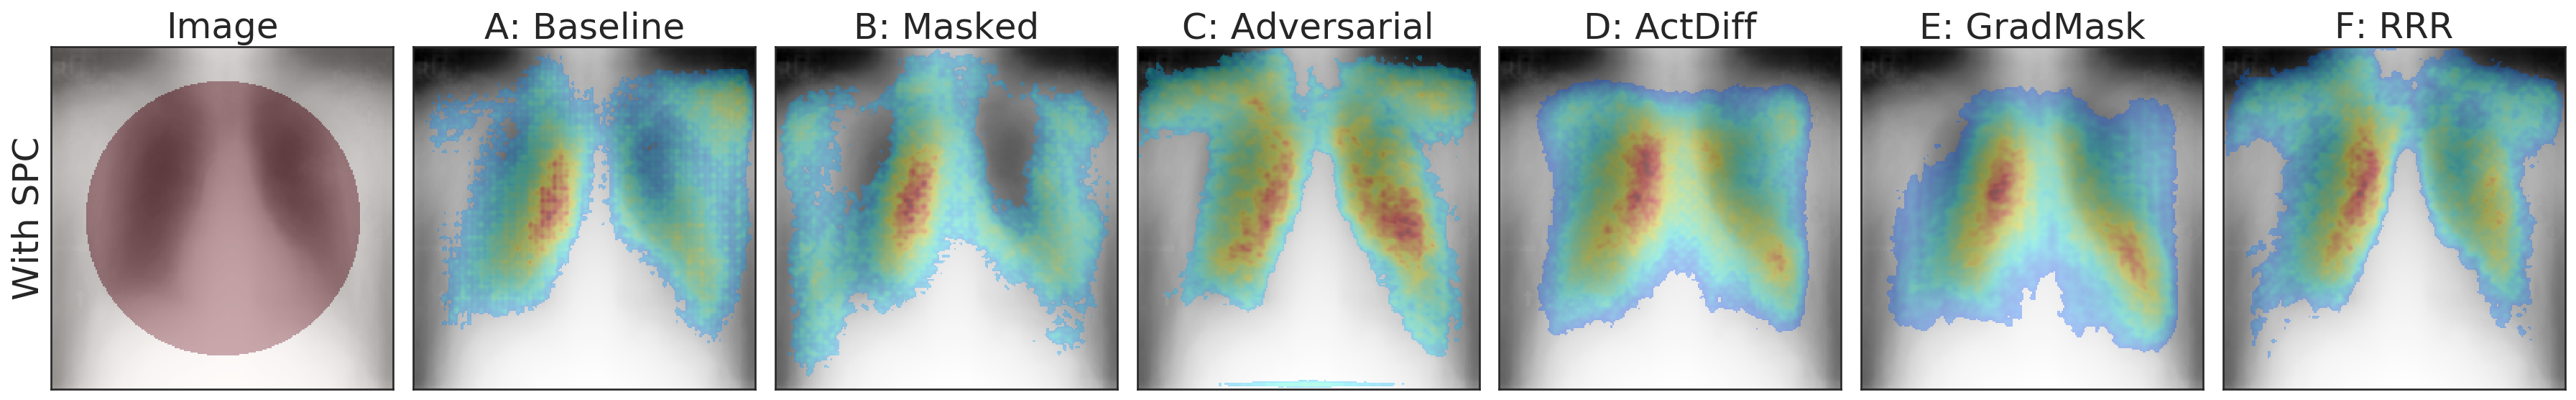

In [115]:
render_mean_grad_wrapper(
    'xray', NSAMPLES,'xray-seeds', 'With SPC', size=224,
    model_name=BEST_MODEL_NAME, model_type='resnet', absoloute=True)

/home/jdv/code/activmask/results/xray-seeds_resnet-bal_clfshuffle/best_model_*


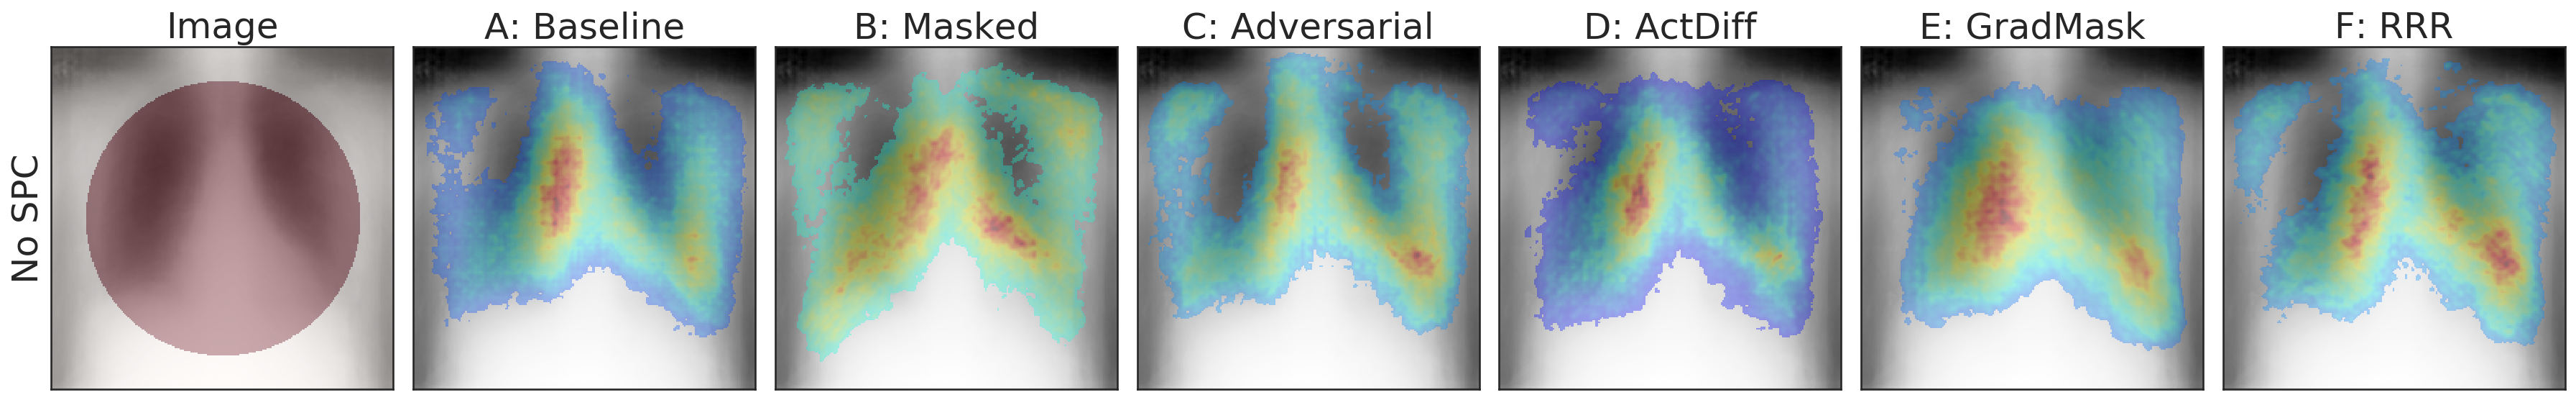

In [116]:
render_mean_grad_wrapper(
    'xray_bal', NSAMPLES,'xray-seeds', 'No SPC', size=224, 
    model_name=BEST_MODEL_NAME, model_type='resnet-bal', absoloute=True)

/home/jdv/code/activmask/results/rsna-seeds_resnet_clfshuffle/best_model_*


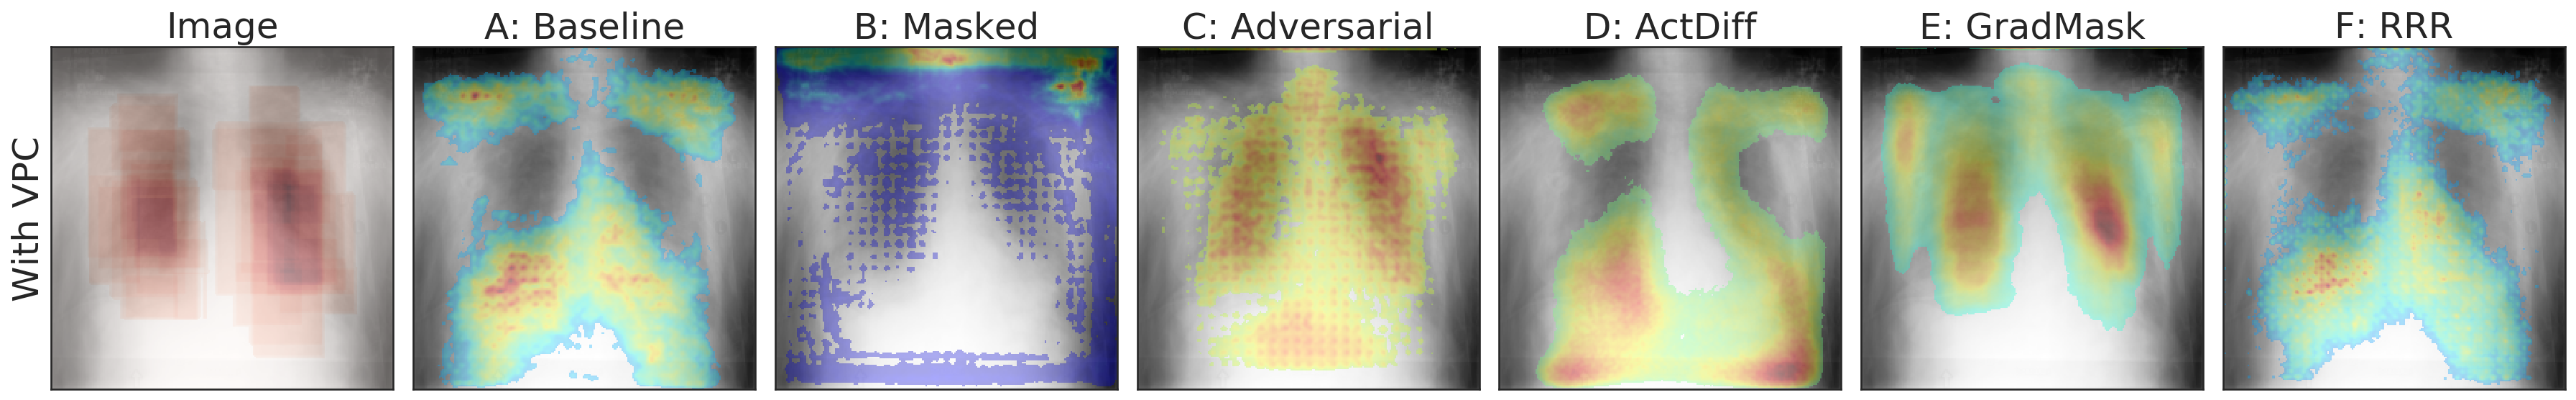

In [117]:
render_mean_grad_wrapper(
    'rsna', NSAMPLES, 'rsna-seeds', 'With VPC', size=224,
    model_name=BEST_MODEL_NAME, model_type='resnet', absoloute=True, crop_mask=50)

/home/jdv/code/activmask/results/rsna-seeds_resnet-bal_clfshuffle/best_model_*


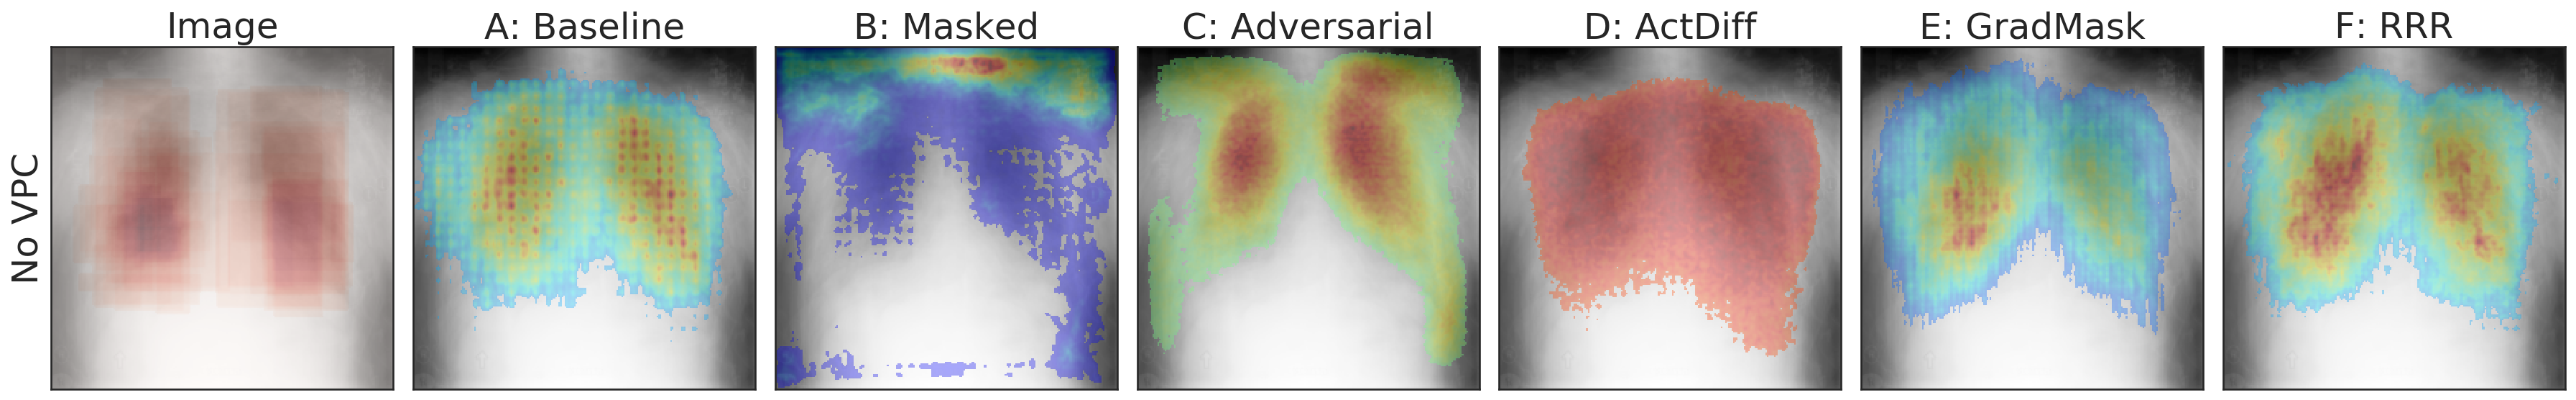

In [118]:
render_mean_grad_wrapper(
    'rsna_bal', NSAMPLES, 'rsna-seeds', 'No VPC', size=224, 
    model_name=BEST_MODEL_NAME, model_type='resnet-bal', absoloute=True, crop_mask=50)

In [ ]:
def plot_scores(df):
    sns.set(style="ticks", palette="pastel")
    #df = df_deduplicate(df)
    #df = loc_melt(df)
    plot = sns.boxplot(x="experiment_name", y="test_auc", data=df)
    #sns.despine(offset=10, trim=True)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')
    plot.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plot_scores(df_experiment_remover(df_xray, 'maskall'))

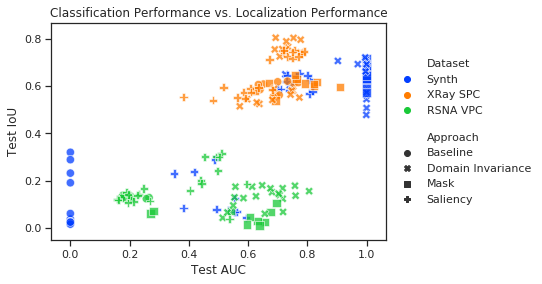

In [142]:
from scipy import stats

def plot_correlation(df):
    sns.set(style="ticks", palette="bright")
    plt.figure(figsize=(6, 4))

    NAME = '\nApproach'
    
    df[NAME] = 'Baseline'
    df[NAME][df['experiment_name'].str.contains('actdiff')] = 'Domain Invariance'
    df[NAME][df['experiment_name'].str.contains('discriminator')] = 'Domain Invariance'
    df[NAME][df['experiment_name'].str.contains('gradmask')] = 'Saliency'
    df[NAME][df['experiment_name'].str.contains('rrr')] = 'Saliency'
    df[NAME][df['experiment_name'].str.contains('maskall')] = 'Mask'
    df[NAME][df['experiment_name'].str.contains('clfmasked')] = 'Mask'
    df[NAME][df['experiment_name'].str.contains('clfshuffle')] = 'Mask'
        
    g = sns.scatterplot(x="test_auc", 
                        y="iou", 
                        hue='Dataset',
                        style=NAME,
                        alpha=0.75,
                        data=df,
                        s=70)
    
    g.set_title("Classification Performance vs. Localization Performance")
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    g.set_xlabel('Test AUC')
    g.set_ylabel('Test IoU')

plot_correlation(
    df_experiment_remover(
        df_experiment_remover(
            pd.concat([df_synth, df_xray, df_rsna], axis=0), 'maskall'), 'clfmasked'))

# MSD Graveyard

In [ ]:
# Collect the seed results experiments.
#df_msd = []
#for pattern in ['livermsd-seeds_', 'pancreasmsd-seeds_', 'cardiacmsd-seeds_', 'colonmsd-seeds_']:
#    df_msd.append(df_experiment_filter(df_performance, pattern)

#df_liver = df_experiment_filter(df_performance, 'livermsd-seeds_')
#df_liver['Dataset'] = "Liver"
#df_liver_loc = calc_loc_scores_wrapper('msd_liver', 'livermsd-seeds', img_size=100)
#df_liver = pd.concat([df_liver.reset_index(drop=True), df_liver_loc], axis=1)

#df_pancreas = df_experiment_filter(df_performance, 'pancreasmsd-seeds_')
#df_pancreas['Dataset'] = "Pancreas"
#df_pancreas_loc = calc_loc_scores_wrapper('msd_pancreas', 'pancreasmsd-seeds', img_size=100)
#df_pancreas = pd.concat([df_pancreas.reset_index(drop=True), df_pancreas_loc], axis=1)

#df_cardiac = df_experiment_filter(df_performance, 'cardiacmsd-seeds_')
#df_cardiac['Dataset'] = "Cardiac"
#df_cardiac_loc = calc_loc_scores_wrapper('msd_cardiac', 'cardiacmsd-seeds', img_size=100)
#df_cardiac = pd.concat([df_cardiac.reset_index(drop=True), df_cardiac_loc], axis=1)

#df_colon = df_experiment_filter(df_performance, 'colonmsd-seeds_')
#df_colon['Dataset'] = "Colon"
#df_colon_loc = calc_loc_scores_wrapper('msd_colon', 'colonmsd-seeds', img_size=100)
#df_colon = pd.concat([df_colon.reset_index(drop=True), df_colon_loc], axis=1)
#df_msd = pd.concat([df_liver, df_pancreas, df_cardiac, df_colon], axis=0)

#with open('notebooks/tables/all_test_results.tex', 'w') as tf:
#    tf.write(make_results_table([df_deduplicate(df_synth), 
#                                 df_deduplicate(df_liver), 
#                                 df_deduplicate(df_cardiac), 
#                                 df_deduplicate(df_pancreas),
#                                 df_deduplicate(df_colon)], sig_digits=2).to_latex(escape=False))

#names = [('livermsd-seeds_resnet', 'MSD Liver', 0.45, ''),
#         ('cardiacmsd-seeds_resnet', 'MSD Cardiac', 0.45, ''),
#         ('pancreasmsd-seeds_resnet', 'MSD Pancreas', 0.45, ''),
#         ('colonmsd-seeds_resnet', 'MSD Colon', 0.45, '')
#        ]
#
#plot_curves(names)

#render_mean_grad_wrapper(load_dataset('msd_cardiac', 1234, nsamples=NSAMPLES), 
#                         'cardiacmsd-search', 'MSD Cardiac', size=100, model_name=BEST_MODEL_NAME)
#render_mean_grad_wrapper(load_dataset('msd_pancreas', 1234, nsamples=NSAMPLES), 
#                         'pancreasmsd-search', 'MSD Pancreas', size=100, model_name=BEST_MODEL_NAME)
#render_mean_grad_wrapper(load_dataset('msd_colon', 1234, nsamples=NSAMPLES), 
#                        'colonmsd-search', 'MSD Colon', size=100, model_name=BEST_MODEL_NAME)
#render_mean_grad_wrapper(load_dataset('msd_liver', 1234, nsamples=NSAMPLES), 
#                        'livermsd-search', 'MSD Liver', size=100, model_name=BEST_MODEL_NAME)